In [1]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt

In [ ]:
# Lecture de la zone d'étude
cadre = gpd.read_file("../../Proximity/data/raw/personal/CadreMarseille.gpkg")

# Le fichier est Lambert 93 (EPSG:2154), on le convertit en WGS84 pour osmnx
if cadre.crs != "EPSG:4326":
    cadre = cadre.to_crs("EPSG:4326")

polygon = cadre.geometry.iloc[0]

# Création du graphe à partir de OSM 
G = ox.graph_from_polygon(polygon, network_type='walk', simplify=True, retain_all=False)

> Le graphe a été généré à partir des données OpenStreetMap à l’aide de la fonction `ox.graph_from_polygon()`, limitée à l’emprise géographique de Marseille.
> Le paramètre `network_type='walk'` permet de ne conserver que les voies accessibles aux piétons, tandis que `simplify=True` fusionne les segments linéaires entre deux intersections afin d’obtenir une topologie plus lisible.
>
> Le paramètre `retain_all=False` garantit la **connectivité du réseau** en ne conservant que le **plus grand composant connexe**, c’est-à-dire le sous-ensemble du graphe dans lequel tous les nœuds sont atteignables les uns depuis les autres.
> Le graphe résultant est de type **`MultiDiGraph`**, ce qui permet de représenter à la fois les **sens de circulation** et la présence de **plusieurs arêtes entre deux mêmes nœuds** (par exemple des rues parallèles ou des voies distinctes pour chaque sens).


In [ ]:
# Type d'objet
type(G)

networkx.classes.multidigraph.MultiDiGraph

> Le graphe obtenu à partir de la fonction `ox.graph_from_polygon()` est un objet de type **`networkx.classes.multidigraph.MultiDiGraph`**.
> Ce format correspond à un **graphe orienté et multi-arêtes**, c’est-à-dire une structure dans laquelle les nœuds représentent les intersections du réseau et les arêtes correspondent aux tronçons de rue reliant ces nœuds.
>
> L’orientation du graphe permet de prendre en compte les **sens de circulation** (par exemple les rues à sens unique ou les escaliers à sens descendant), tandis que la possibilité d’avoir plusieurs arêtes entre deux mêmes nœuds reflète la présence de **voies parallèles ou superposées** (comme une voie de service et une voie principale).

In [11]:
# Affiche trois premiers noeuds
list(G.nodes(data=True))[:3]

[(12116512, {'y': 43.2948921, 'x': 5.6357888, 'street_count': 3}),
 (12116520, {'y': 43.2962654, 'x': 5.6347066, 'street_count': 3}),
 (12116524, {'y': 43.2963012, 'x': 5.6338106, 'street_count': 3})]

In [10]:
# Quelques infos utiles
def graph_info(G):
    print(f"Type du graphe : {type(G).__name__}")
    print(f"Nombre de nœuds : {G.number_of_nodes()}")
    print(f"Nombre d’arêtes : {G.number_of_edges()}")
    print(f"Est orienté : {G.is_directed()}")
    print(f"Est connexe : {nx.is_weakly_connected(G) if G.is_directed() else nx.is_connected(G)}")

graph_info(G)

Type du graphe : MultiDiGraph
Nombre de nœuds : 113230
Nombre d’arêtes : 302816
Est orienté : True
Est connexe : True


In [12]:
# Trouver un nœud central (géométriquement au milieu)
center_node = list(G.nodes())[len(G)//2]

# Extraire un sous-graphe autour du centre, dans un rayon de 600 m
subG = ox.truncate.truncate_graph_dist(G, center_node, max_dist=600)

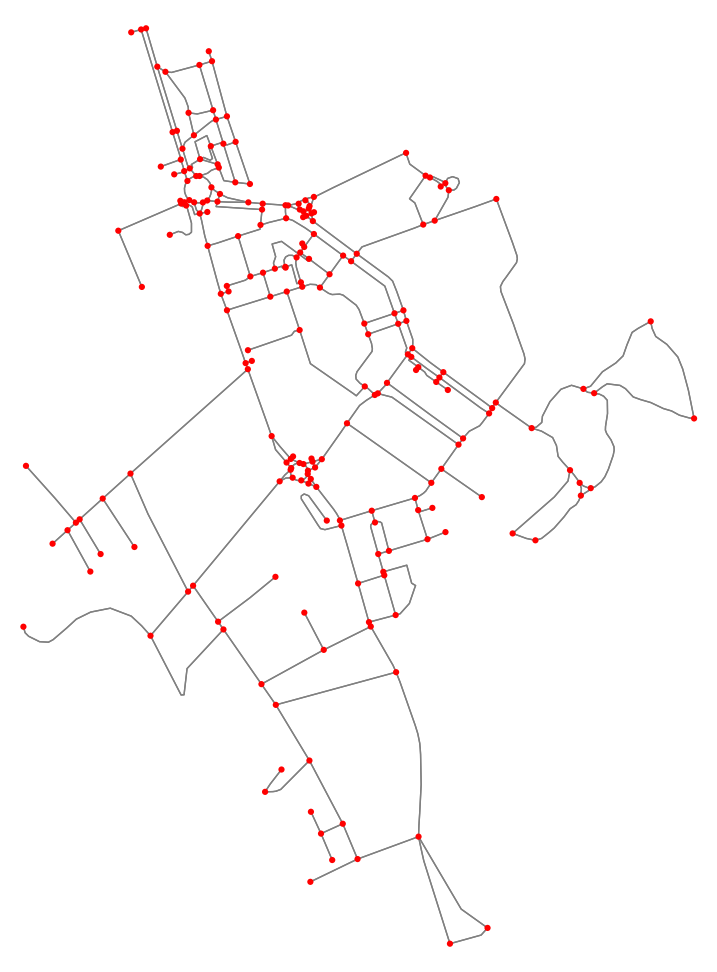

In [51]:
fig, ax = plt.subplots(figsize=(9, 20))
ox.plot_graph(
    subG,
    ax=ax,
    node_size=20,
    node_color='red',
    edge_color='gray',
    bgcolor='white'
)
plt.show()

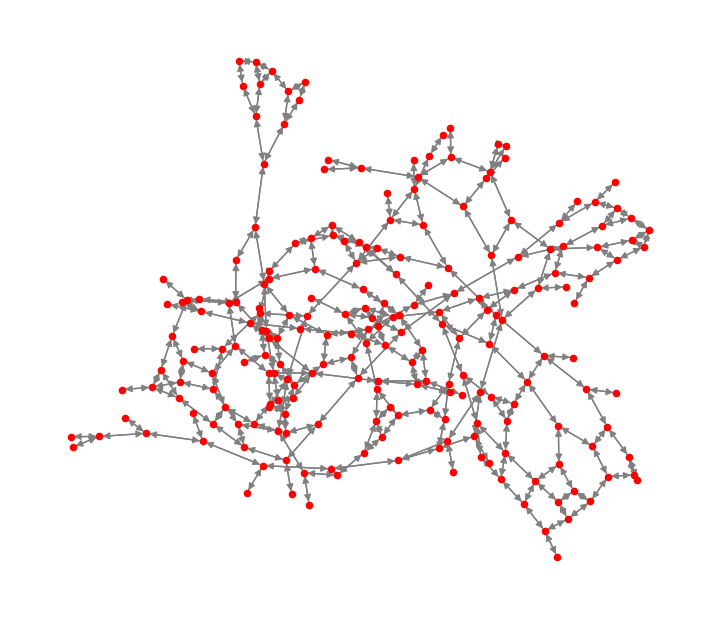

In [ ]:

plt.figure(figsize=(7,6))
nx.draw(subG, node_size=20, edge_color='gray', node_color='red')
plt.show()

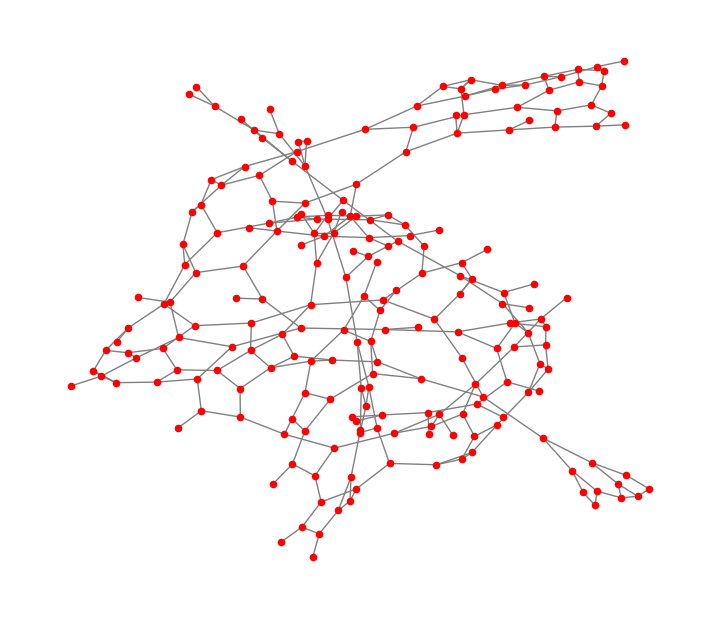

In [ ]:
# conversion en Graphe non orienté
subG_undirected = subG.to_undirected()

plt.figure(figsize=(7,6))
nx.draw(subG_undirected, node_size=20, edge_color='gray', node_color='red')
plt.show()

In [41]:
nodes, edges = ox.graph_to_gdfs(subG)

In [45]:
nodes.head()

,y,x,street_count,highway,geometry
osmid,,,,,
307995439,43.223974,5.404080,3,NaN,POINT (5.40408 43.22397)
307995441,43.225115,5.403621,4,NaN,POINT (5.40362 43.22512)
307995446,43.227355,5.402922,3,NaN,POINT (5.40292 43.22735)
308240131,43.231875,5.400467,3,NaN,POINT (5.40047 43.23187)
308240132,43.231895,5.400530,3,NaN,POINT (5.40053 43.2319)


In [46]:
edges.head()

osmid       highway  oneway reversed   length  \
u         v          key                                                       
307995439 1811860738 0     170028245         track   False     True   49.717   
          307995441  0    1097560336  unclassified   False    False  132.310   
307995441 1739340029 0     162097600   residential   False     True   76.997   
          1740315362 0     161981629  unclassified   False    False  199.676   
          1811860738 0     453094611          path   False    False  138.016   

                                                                   geometry  \
u         v          key                                                      
307995439 1811860738 0    LINESTRING (5.40408 43.22397, 5.40454 43.22407...   
          307995441  0    LINESTRING (5.40408 43.22397, 5.40377 43.22469...   
307995441 1739340029 0      LINESTRING (5.40362 43.22512, 5.40273 43.22488)   
          1740315362 0    LINESTRING (5.40362 43.22512, 5.40363 43.22524...   
          1811860738 0    LINESTRING (5.40362 43.22512, 5.40424 43.22434...   

                         lanes                name junction service maxspeed  \
u         v          key                                                       
307995439 1811860738 0     NaN                 NaN      NaN     NaN      NaN   
          307995441  0       2   Chemin de Sormiou      NaN     NaN      NaN   
307995441 1739340029 0     NaN  Impasse de l'Aspic      NaN     NaN      NaN   
          1740315362 0       2   Chemin de Sormiou      NaN     NaN      NaN   
          1811860738 0     NaN                 NaN      NaN     NaN      NaN   

                         access bridge  
u         v          key                
307995439 1811860738 0      NaN    NaN  
          307995441  0      NaN    NaN  
307995441 1739340029 0      NaN    NaN  
          1740315362 0      NaN    NaN  
          1811860738 0      NaN    NaN

In [47]:
nodes_und, edges_und = ox.graph_to_gdfs(subG_undirected)

In [48]:
nodes_und.head()

,y,x,street_count,highway,geometry
osmid,,,,,
307995439,43.223974,5.404080,3,NaN,POINT (5.40408 43.22397)
307995441,43.225115,5.403621,4,NaN,POINT (5.40362 43.22512)
307995446,43.227355,5.402922,3,NaN,POINT (5.40292 43.22735)
308240131,43.231875,5.400467,3,NaN,POINT (5.40047 43.23187)
308240132,43.231895,5.400530,3,NaN,POINT (5.40053 43.2319)


In [49]:
edges_und.head()

osmid       highway  oneway reversed   length  \
u         v          key                                                       
307995439 1811860738 0     170028245         track   False    False   49.717   
          307995441  0    1097560336  unclassified   False     True  132.310   
307995441 1739340029 0     162097600   residential   False    False   76.997   
          1740315362 0     161981629  unclassified   False     True  199.676   
          1811860738 0     453094611          path   False     True  138.016   

                                                                   geometry  \
u         v          key                                                      
307995439 1811860738 0    LINESTRING (5.40463 43.22414, 5.40454 43.22407...   
          307995441  0    LINESTRING (5.40362 43.22512, 5.40367 43.22496...   
307995441 1739340029 0      LINESTRING (5.40362 43.22512, 5.40273 43.22488)   
          1740315362 0    LINESTRING (5.40329 43.22687, 5.40335 43.22676...   
          1811860738 0    LINESTRING (5.40463 43.22414, 5.40424 43.22434...   

                         lanes                name junction service maxspeed  \
u         v          key                                                       
307995439 1811860738 0     NaN                 NaN      NaN     NaN      NaN   
          307995441  0       2   Chemin de Sormiou      NaN     NaN      NaN   
307995441 1739340029 0     NaN  Impasse de l'Aspic      NaN     NaN      NaN   
          1740315362 0       2   Chemin de Sormiou      NaN     NaN      NaN   
          1811860738 0     NaN                 NaN      NaN     NaN      NaN   

                         access bridge  
u         v          key                
307995439 1811860738 0      NaN    NaN  
          307995441  0      NaN    NaN  
307995441 1739340029 0      NaN    NaN  
          1740315362 0      NaN    NaN  
          1811860738 0      NaN    NaN

In [52]:
nodes, edges = ox.graph_to_gdfs(G)

In [53]:
edges.head()

osmid  ref                 name    highway  \
u        v          key                                                    
12116512 1062102835 0    1185889490  D 2  Route de Saint-Pons  secondary   
         12116520   0       2682531  NaN                  NaN    service   
         12116535   0    1185889490  D 2  Route de Saint-Pons  secondary   
12116520 1846672547 0       3626015  D 2  Route de Saint-Pons  secondary   
         12116512   0       2682531  NaN                  NaN    service   

                         oneway reversed   length  \
u        v          key                             
12116512 1062102835 0     False     True   19.065   
         12116520   0     False    False  289.179   
         12116535   0     False    False   77.251   
12116520 1846672547 0     False     True    7.443   
         12116512   0     False     True  289.179   

                                                                  geometry  \
u        v          key                                                      
12116512 1062102835 0      LINESTRING (5.63579 43.29489, 5.63563 43.29502)   
         12116520   0    LINESTRING (5.63579 43.29489, 5.63641 43.29524...   
         12116535   0    LINESTRING (5.63579 43.29489, 5.63618 43.29461...   
12116520 1846672547 0      LINESTRING (5.63471 43.29627, 5.63464 43.29631)   
         12116512   0    LINESTRING (5.63471 43.29627, 5.63477 43.29633...   

                        lanes maxspeed junction access service bridge tunnel  \
u        v          key                                                        
12116512 1062102835 0     NaN      NaN      NaN    NaN     NaN    NaN    NaN   
         12116520   0     NaN      NaN      NaN    NaN     NaN    NaN    NaN   
         12116535   0     NaN      NaN      NaN    NaN     NaN    NaN    NaN   
12116520 1846672547 0     NaN      NaN      NaN    NaN     NaN    NaN    NaN   
         12116512   0     NaN      NaN      NaN    NaN     NaN    NaN    NaN   

                        width est_width  
u        v          key                  
12116512 1062102835 0     NaN       NaN  
         12116520   0     NaN       NaN  
         12116535   0     NaN       NaN  
12116520 1846672547 0     NaN       NaN  
         12116512   0     NaN       NaN

In [ ]:
nodes.head()

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
12116512,43.294892,5.635789,3,NaN,NaN,POINT (5.63579 43.29489)
12116520,43.296265,5.634707,3,NaN,NaN,POINT (5.63471 43.29627)
12116524,43.296301,5.633811,3,NaN,NaN,POINT (5.63381 43.2963)
12116526,43.296415,5.633292,3,NaN,NaN,POINT (5.63329 43.29641)
12116535,43.294384,5.636438,3,NaN,NaN,POINT (5.63644 43.29438)


: 

In [ ]:
# Sauvegarder en GeoPackage (format parfait pour QGIS)
edges.to_file("marseille_walk_edges.gpkg", layer="edges", driver="GPKG")
nodes.to_file("marseille_walk_nodes.gpkg", layer="nodes", driver="GPKG")

In [ ]:
import geopandas as gpd
import networkx as nx
from shapely.geometry import LineString

edges_gdf = gpd.read_file("../../Proximity/data/processed/roads_network/osm_foot_network_Marseille_2025-10-06.gpkg")

In [2]:
edges_gdf.head()

,osm_id,highway,name,access,foot,surface,incline,smoothness,width,sidewalk,crossing,lit,bridge,tunnel,layer,oneway,geometry
0,2682531,service,,,,,,,,,,,,,0,no,"LINESTRING (913982.648 6247541.048, 914032.152..."
1,2699768,path,,,,,,,,,,,,,0,no,"LINESTRING (909518.351 6239066.723, 909533.383..."
2,2699769,path,,,,,,,,,,,,,0,no,"LINESTRING (909448.07 6239122.435, 909435.263 ..."
3,3617343,primary,,,,asphalt,,,,,,,,,0,no,"LINESTRING (910535.741 6250520.857, 910540.587..."
4,3617344,primary,,,,,,,,,,,,,0,no,"LINESTRING (910571.976 6250128.531, 910573.41 ..."


In [ ]:
G = nx.Graph()

In [ ]:
for _, row in edges_gdf.iterrows():
    geom = row.geometry
    if isinstance(geom, LineString):
        start, end = geom.coords[0], geom.coords[-1]
        G.add_edge(start, end, length=geom.length)

print(f"Graphe créé : {len(G.nodes)} nœuds et {len(G.edges)} arêtes")

edges_gdf.to_file("edges_export.gpkg", driver="GPKG")

Graphe créé : 139735 nœuds et 96402 arêtes


In [ ]:
import geopandas as gpd
import networkx as nx
import momepy 

edges_gdf = gpd.read_file("../../Proximity/data/processed/roads_network/osm_foot_network_Marseille_2025-10-06.gpkg")

print(f" Réseau chargé : {len(edges_gdf)} tronçons")
print(edges_gdf.head())

# Construire un graphe topologique (reconnaissance des intersections)
# approach="primal" : un nœud = intersection, une arête = tronçon
G = momepy.gdf_to_nx(edges_gdf, approach="primal")

print(f" Graphe construit : {len(G.nodes)} nœuds, {len(G.edges)} arêtes")

# (Optionnel) Extraire à nouveau les arêtes sous forme GeoDataFrame
edges_out = momepy.nx_to_gdf(G, points=False, lines=True)

# (Optionnel) Exporter le graphe au format GeoPackage
edges_out.to_file("osm_foot_network_Marseille_graph_topo.gpkg", driver="GPKG")

print(" Fichier exporté avec topologie reconstruite.")

 Réseau chargé : 96901 tronçons
    osm_id  highway name access foot  surface incline smoothness width  \
0  2682531  service                                                      
1  2699768     path                                                      
2  2699769     path                                                      
3  3617343  primary                   asphalt                            
4  3617344  primary                                                      

  sidewalk crossing lit bridge tunnel layer oneway  \
0                                         0     no   
1                                         0     no   
2                                         0     no   
3                                         0     no   
4                                         0     no   

                                            geometry  
0  LINESTRING (913982.648 6247541.048, 914032.152...  
1  LINESTRING (909518.351 6239066.723, 909533.383...  
2  LINESTRING (909448.07 6239122.

In [18]:
import geopandas as gpd
import networkx as nx
import momepy 

edges_gdf = gpd.read_file("../../Proximity/data/processed/roads_network/osm_foot_network_Marseille_2025-10-06.gpkg")

print(f" Réseau chargé : {len(edges_gdf)} tronçons")
print(edges_gdf.head())

# Construire un graphe topologique (reconnaissance des intersections)
# approach="primal" : un nœud = intersection, une arête = tronçon
G = momepy.gdf_to_nx(edges_gdf, approach="dual")

print(f" Graphe construit : {len(G.nodes)} nœuds, {len(G.edges)} arêtes")

# (Optionnel) Extraire à nouveau les arêtes sous forme GeoDataFrame
edges_out = momepy.nx_to_gdf(G, points=False, lines=True)

# (Optionnel) Exporter le graphe au format GeoPackage
edges_out.to_file("osm_foot_network_Marseille_graph_topo_dual.gpkg", driver="GPKG")

print(" Fichier exporté avec topologie reconstruite.")

 Réseau chargé : 96901 tronçons
    osm_id  highway name access foot  surface incline smoothness width  \
0  2682531  service                                                      
1  2699768     path                                                      
2  2699769     path                                                      
3  3617343  primary                   asphalt                            
4  3617344  primary                                                      

  sidewalk crossing lit bridge tunnel layer oneway  \
0                                         0     no   
1                                         0     no   
2                                         0     no   
3                                         0     no   
4                                         0     no   

                                            geometry  
0  LINESTRING (913982.648 6247541.048, 914032.152...  
1  LINESTRING (909518.351 6239066.723, 909533.383...  
2  LINESTRING (909448.07 6239122.

In [2]:
import osmium
import shapely.wkb as wkblib
import geopandas as gpd
from shapely.geometry import Point, LineString
from tqdm import tqdm
from collections import defaultdict

def extract_reseau_topologique(input_pbf):
    wkbfab = osmium.geom.WKBFactory()
    ways = []
    nodes_dict = {}
    total_ways = 0

    class WayCounter(osmium.SimpleHandler):
        def way(self, w):
            nonlocal total_ways
            total_ways += 1

    print("Counting ways...")
    counter = WayCounter()
    counter.apply_file(str(input_pbf), locations=False)
    print(f"Total number of ways: {total_ways}")

    print("Extracting pedestrian network...")
    pbar = tqdm(total=total_ways, desc="Processing ways")

    class FootwayHandler(osmium.SimpleHandler):
        def way(self, w):
            try:
                tags = w.tags
                highway = tags.get('highway', '')
                access = tags.get('access', '')
                foot = tags.get('foot', '')

                # Liste des types de routes piétonnes autorisées
                highway_whitelist = [
                    'primary', 'primary_link', 'secondary', 'secondary_link', 'tertiary',
                    'tertiary_link', 'unclassified', 'residential', 'road', 'living_street',
                    'service', 'track', 'path', 'steps', 'pedestrian', 'platform',
                    'footway', 'pier'
                ]
                if highway not in highway_whitelist:
                    pbar.update(1)
                    return
                if foot == 'no' or highway == 'platform':
                    pbar.update(1)
                    return

                wkb = wkbfab.create_linestring(w)
                geom = wkblib.loads(wkb, hex=True)

                # --- Création des nœuds u/v (extrémités du tronçon)
                start = Point(geom.coords[0])
                end = Point(geom.coords[-1])

                # Ajout des nœuds uniques
                for pt in [start, end]:
                    coord = (pt.x, pt.y)
                    if coord not in nodes_dict:
                        nodes_dict[coord] = len(nodes_dict)

                u = nodes_dict[(start.x, start.y)]
                v = nodes_dict[(end.x, end.y)]

                way_info = {
                    'osm_id': w.id,
                    'u': u,
                    'v': v,
                    'geometry': geom,
                    'highway': highway,
                    'name': tags.get('name', ''),
                    'access': access,
                    'foot': foot,
                    'surface': tags.get('surface', ''),
                    'incline': tags.get('incline', ''),
                    'smoothness': tags.get('smoothness', ''),
                    'width': tags.get('width', ''),
                    'sidewalk': tags.get('sidewalk', ''),
                    'crossing': tags.get('crossing', ''),
                    'lit': tags.get('lit', ''),
                    'bridge': tags.get('bridge', ''),
                    'tunnel': tags.get('tunnel', ''),
                    'layer': tags.get('layer', '0'),
                    'oneway': tags.get('oneway', 'no')
                }
                ways.append(way_info)

            except Exception as e:
                print(f"Error processing way {w.id}: {e}")
            finally:
                pbar.update(1)

    handler = FootwayHandler()
    handler.apply_file(str(input_pbf), locations=True)
    pbar.close()

    # Création des GeoDataFrames
    edges_gdf = gpd.GeoDataFrame(ways, crs="EPSG:4326")
    nodes_list = [{'node_id': nid, 'geometry': Point(xy)} for xy, nid in nodes_dict.items()]
    nodes_gdf = gpd.GeoDataFrame(nodes_list, crs="EPSG:4326")

    print(f"Réseau extrait : {len(edges_gdf)} arêtes, {len(nodes_gdf)} nœuds")
    return nodes_gdf, edges_gdf

In [3]:
nodes_gdf, edges_gdf = extract_reseau_topologique("../../Proximity/data/raw/osm/provence-alpes-cote-d-azur-latest.osm.pbf")


Counting ways...
Total number of ways: 5184783
Extracting pedestrian network...


Processing ways: 9522720it [01:49, 87176.22it/s]                              


Réseau extrait : 846846 arêtes, 1227394 nœuds


In [4]:
# Export en deux couches
output_path_nodes = "../../Proximity/data/processed/roads_network/osrm_foot_nodes_network_Marseille.gpkg"
output_path_edges = "../../Proximity/data/processed/roads_network/osrm_foot_edges_network_Marseille.gpkg"
nodes_gdf.to_file(output_path_nodes, layer="nodes", driver="GPKG")
edges_gdf.to_file(output_path_edges, layer="edges", driver="GPKG")

print("Réseau piéton exporté avec topologie (nodes + edges).")

Réseau piéton exporté avec topologie (nodes + edges).


In [1]:
custom_filter = (
    '["highway"~"primary|primary_link|secondary|secondary_link|tertiary|tertiary_link|'
    'unclassified|residential|road|living_street|service|track|path|steps|pedestrian|footway|pier"]'
    '["foot"!~"no"]'
)

In [2]:
import osmnx as ox

# Exemple : réseau piéton complet de Marseille
G = ox.graph_from_place(
    "Marseille, France",
    custom_filter=custom_filter,
    simplify=True,
    retain_all=True
)

# Convertir en GeoDataFrame si tu veux inspecter
nodes, edges = ox.graph_to_gdfs(G)

In [3]:
nodes, edges = ox.graph_to_gdfs(G)

In [4]:
# Sauvegarder en GeoPackage (format parfait pour QGIS)
edges.to_file("marseille_walk_edges.gpkg", layer="edges", driver="GPKG")
nodes.to_file("marseille_walk_nodes.gpkg", layer="nodes", driver="GPKG")